In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from skimage.io import imread , imshow
from skimage import color
from skimage import measure
import math

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    ORIG = None
    WCSS = None
    pLABEL = None
    KMEAN = None
    
    def __init__(self, image):
        self.IMAGE = image
        
    def dominantColors(self):
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
        kmeans.fit(self.IMAGE)
        
        self.KMEAN = kmeans
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #find label of purple color
        #self.pLABEL = kmeans.predict([[128,0,128]])
        self.pLABEL = kmeans.predict([[150,255,127]])
        
        #returning after converting to integer from float
        return self.COLORS
    
    def show(self):
        imshow(self.ORIG)
        
    def elbow(self):
        #read image
        img = cv2.imread(self.IMAGE)
        
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
        
        for i in range(img.shape[0]):
            for j in range(0,2):
                img[i,j,:] = 0
                img[j,i,:] = 0
                last_idx = img.shape[1]-1-j
                img[i,last_idx,:] = 0
                img[last_idx,i,:] = 0

        self.ORIG = img.copy()
           
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #Elbow method
        wcss = []
        for i in range(1, 10):
            kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
            kmeans.fit(self.IMAGE)
            wcss.append(kmeans.inertia_)
        self.WCSS = wcss
        plt.plot(range(1, 10), wcss)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
        
    def findK(self):
        m = (self.WCSS[0]-self.WCSS[8])/(1-9)
        c = self.WCSS[0]-m*1
        A=m
        B=-1
        maxD = 0
        K = 0
        for x1,y1 in enumerate(self.WCSS,1):
            d = abs(A*x1+B*y1+c)/math.sqrt(A**2+B**2)
            if d > maxD:
                maxD = d
                self.CLUSTERS=x1+1
        print('found :'+str(self.CLUSTERS)+' group')
        return self.CLUSTERS

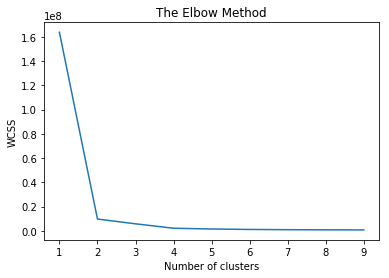

found :3 group


In [2]:
img = 'segmentation_WBC-master/compare/0.png'
orig = 'segmentation_WBC-master/testset/0.png'
dc = DominantColors(img) 
dc.elbow()
dc.findK()
dc.IMAGE
dc.COLORS

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([[ 1.62220721e+02,  3.21261261e+01,  1.84710586e+02],
       [-5.50670620e-12,  1.45661261e-12, -8.52651283e-14],
       [ 1.27431831e+02,  8.91340559e+01,  2.16540217e+02],
       [ 1.17327586e+01,  2.80215517e+01,  1.89340517e+02],
       [ 1.35545241e+02,  3.52502938e+01,  2.04483549e+02]])

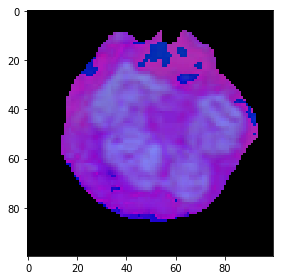

In [3]:
dc.dominantColors()
dc.show()
dc.COLORS

In [4]:
dc.COLORS

array([[ 1.62220721e+02,  3.21261261e+01,  1.84710586e+02],
       [-5.50670620e-12,  1.45661261e-12, -8.52651283e-14],
       [ 1.27431831e+02,  8.91340559e+01,  2.16540217e+02],
       [ 1.17327586e+01,  2.80215517e+01,  1.89340517e+02],
       [ 1.35545241e+02,  3.52502938e+01,  2.04483549e+02]])

In [5]:
dc.LABELS
neucleus = np.reshape(dc.LABELS, (-1, dc.ORIG.shape[1]))

In [6]:
cytoplasm = neucleus.copy()
cell = neucleus.copy()

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


4

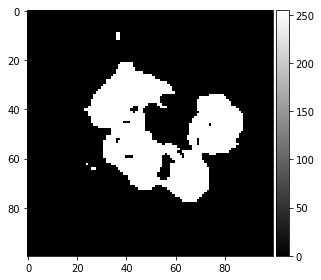

In [7]:
label = dc.KMEAN.predict([[125,23,212]])[0]
for i in range(0,neucleus.shape[0]):
    for j in range(0,neucleus.shape[1]):
        if neucleus[i][j] == dc.pLABEL[0] :
            neucleus[i][j] = 255
        else:
            neucleus[i][j] = 0
        if cytoplasm[i][j] == label:
            cytoplasm[i][j] = 255
        else:
            cytoplasm[i][j] = 0
imshow(neucleus,cmap='gray')
label

In [8]:
# from skimage.morphology import erosion, dilation, opening,closing
# from skimage.morphology import square,disk,diamond,remove_small_objects,remove_small_holes
# neucleus = neucleus.astype(bool)
# neucleus = remove_small_objects(neucleus, 400)
# from skimage.morphology import convex_hull_image
# chull = convex_hull_image(neucleus)
# imshow(chull)

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


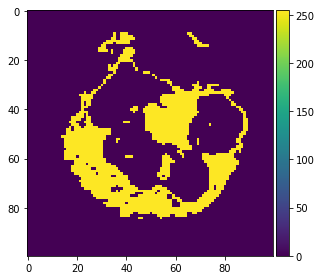

In [9]:
imshow(cytoplasm)

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

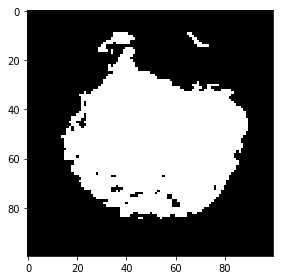

In [10]:
import numpy as np
from skimage.morphology import square,disk,diamond,remove_small_objects,remove_small_holes
from skimage.morphology import erosion, dilation, opening,closing
#opened = opening(cytoplasm+neucleus, square(2))
opened = cytoplasm+neucleus
for i in range(0,opened.shape[0]):
    for j in range(0,opened.shape[1]):
        if opened[i][j] <200:
            opened[i][j] =0
opened= opened.astype(bool)
imshow(opened,cmap='gray')
opened

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


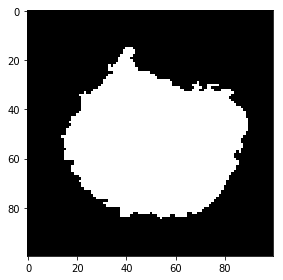

In [11]:

opened = remove_small_objects(opened, 400)
opened = remove_small_holes(opened,1600)
imshow(opened)

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

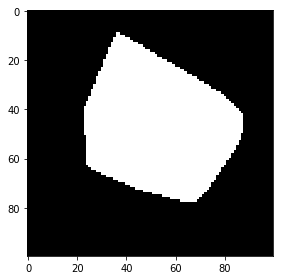

In [12]:
from skimage.morphology import convex_hull_image
chull = convex_hull_image(neucleus)
chull2 = convex_hull_image(opened)
imshow(chull)
chull

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

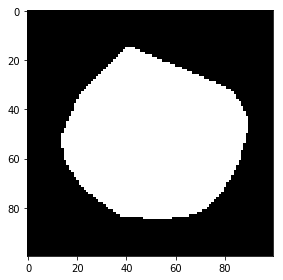

In [13]:
#chull2 = convex_hull_image(opened)
imshow(chull2)
chull2

In [14]:

img = cv2.imread(orig)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


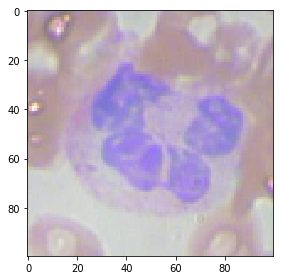

In [15]:
imshow(img)

In [16]:
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        if opened[i][j] ==0 :
            img[i][j] = 0

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


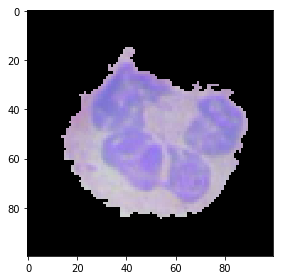

In [17]:
imshow(img)